In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score, roc_curve, precision_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
features = pd.read_csv('data/training_set_features.csv')
labels = pd.read_csv('data/training_set_labels.csv')

In [3]:
flu_df = pd.merge(features, labels, on='respondent_id', how='outer')

In [4]:
flu_df

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,NaN,NaN,0,0
26703,26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea,0,0
26704,26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN,0,1
26705,26705,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Rent,Employed,lrircsnp,Non-MSA,1.0,0.0,fcxhlnwr,haliazsg,0,0


In [5]:
flu_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [6]:
flu_df.corr()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,h1n1_vaccine,seasonal_vaccine
respondent_id,1.000000,0.017839,0.003425,-0.008475,0.009638,-0.006644,0.011105,0.004539,0.009011,0.007575,...,0.005912,0.000958,-0.002270,0.005935,-0.005291,0.009563,0.000187,-0.003726,-0.003280,-0.004652
h1n1_concern,0.017839,1.000000,0.062522,0.090301,0.233713,0.156032,0.293565,0.255031,0.246424,0.248016,...,0.239604,0.377033,0.360070,0.235136,0.333990,0.225731,-0.015658,0.050525,0.121929,0.154828
h1n1_knowledge,0.003425,0.062522,1.000000,-0.010836,0.088839,0.030050,0.089785,-0.048898,-0.068219,0.086162,...,0.121009,0.073086,-0.019501,0.086103,0.076825,-0.062483,0.024874,0.050583,0.117951,0.120152
behavioral_antiviral_meds,-0.008475,0.090301,-0.010836,1.000000,0.049247,0.146261,0.064119,0.106287,0.127679,0.070868,...,0.030211,0.105163,0.079091,0.015003,0.085315,0.084305,0.044900,0.084822,0.040608,0.006277
behavioral_avoidance,0.009638,0.233713,0.088839,0.049247,1.000000,0.064946,0.338130,0.227675,0.220348,0.335335,...,0.112300,0.117851,0.131405,0.119554,0.129504,0.082942,0.019122,0.040328,0.047690,0.076395
behavioral_face_mask,-0.006644,0.156032,0.030050,0.146261,0.064946,1.000000,0.083363,0.180907,0.163382,0.104335,...,0.037651,0.131165,0.107129,0.041556,0.110161,0.090009,0.013991,0.005826,0.070498,0.050083
behavioral_wash_hands,0.011105,0.293565,0.089785,0.064119,0.338130,0.083363,1.000000,0.195364,0.192619,0.365064,...,0.136987,0.168711,0.150024,0.138517,0.172464,0.088029,0.009669,0.047764,0.074712,0.112414
behavioral_large_gatherings,0.004539,0.255031,-0.048898,0.106287,0.227675,0.180907,0.195364,1.000000,0.584085,0.253683,...,0.052299,0.126463,0.185924,0.078491,0.132865,0.135446,-0.031938,-0.009449,0.017822,0.064025
behavioral_outside_home,0.009011,0.246424,-0.068219,0.127679,0.220348,0.163382,0.192619,0.584085,1.000000,0.267719,...,0.050748,0.125549,0.174834,0.067469,0.120237,0.138133,-0.027527,-0.009558,0.021768,0.053509
behavioral_touch_face,0.007575,0.248016,0.086162,0.070868,0.335335,0.104335,0.365064,0.253683,0.267719,1.000000,...,0.104126,0.146080,0.131772,0.105798,0.143735,0.090097,-0.000553,0.023606,0.071648,0.120228


In [7]:
X=flu_df.drop('seasonal_vaccine', axis=1)
y=flu_df['seasonal_vaccine']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=12)

In [10]:
numbers=['h1n1_concern', 'h1n1_knowledge','opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults', 'household_children']
onehots=['race', 'sex',  'marital_status', 'income_poverty', 'age_group', 'education', 'rent_or_own','employment_status', 'hhs_geo_region', 'census_msa', 'employment_industry', 'employment_occupation']
binary= ['behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months', 'health_worker', 'health_insurance', 'h1n1_vaccine']

In [11]:
numbers_pipeline = Pipeline(steps=[
    ('impute_nums', SimpleImputer(strategy='most_frequent', add_indicator=True)),
    ('num', StandardScaler())])

In [12]:
onehots_pipeline = Pipeline(steps=[
    ('impute_ohe', SimpleImputer(strategy='most_frequent', add_indicator=True)),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))])

In [13]:
binary_pipeline = Pipeline(steps=[('impute_bin', SimpleImputer(strategy='most_frequent', add_indicator=True))])

In [14]:
col_tr = ColumnTransformer(transformers=[('num', numbers_pipeline, numbers),
                                        ('ohe', onehots_pipeline, onehots),
                                        ('bin', binary_pipeline, binary)],
                          remainder='drop', sparse_threshold=0)

In [15]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [16]:
dummy.score(X_train, y_train)

0.5326510234648028

# Decision Tree

In [17]:
tree_pipe = Pipeline(steps=[('ct', col_tr), 
                           ('dtree', DecisionTreeClassifier(random_state=12))])

In [18]:
tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('impute_nums',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('num',
                                                                   StandardScaler())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'opinion_h1n1_vacc_effective',
                                                   'opinion_h1n1_risk',
                                                   'opinion_h1n1_sick_from_vacc',
                                       

In [19]:
cv_results = cross_validate(estimator=tree_pipe, X=X_train, y=y_train, cv=5,
                            return_train_score=True)
cv_results

{'fit_time': array([1.53389883, 1.48954105, 1.50577784, 1.51427317, 1.57846594]),
 'score_time': array([0.06876993, 0.04896998, 0.05145717, 0.0483017 , 0.06948495]),
 'test_score': array([0.71018472, 0.70968547, 0.72241638, 0.71867199, 0.71767349]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [20]:
tree_y_train = tree_pipe.predict(X_train)
tree_y_pred = tree_pipe.predict(X_test)

In [21]:
print(precision_score(y_train, tree_y_train))
print(precision_score(y_test, tree_y_pred))

1.0
0.6860133206470028


In [27]:
tree_params = [{'dtree__max_depth': [4, 6, 8,], 'dtree__min_samples_split': [2, 4], 'dtree__min_samples_leaf': [1, 2]}]
gs_tree = GridSearchCV(tree_pipe, param_grid=tree_params, scoring='precision')
gs_tree.fit(X_train, y_train)
gs_tree.best_params_

{'dtree__max_depth': 6,
 'dtree__min_samples_leaf': 1,
 'dtree__min_samples_split': 2}

In [28]:
gs_tree.best_score_

0.7885146526102459

In [29]:
tree_params = [{'dtree__max_depth': [5, 6, 7,], 'dtree__min_samples_split': [2, 4], 'dtree__min_samples_leaf': [1, 2]}]
gs_tree = GridSearchCV(tree_pipe, param_grid=tree_params, scoring='precision')
gs_tree.fit(X_train, y_train)
print(gs_tree.best_params_)
print(gs_tree.best_score_)

{'dtree__max_depth': 6, 'dtree__min_samples_leaf': 1, 'dtree__min_samples_split': 2}
0.7885146526102459


In [33]:
best_tree = Pipeline(steps=[('ct', col_tr), 
                           ('dtree', DecisionTreeClassifier(random_state=12, max_depth=6, min_samples_split=2, min_samples_leaf=1))])
best_tree.fit(X_train, y_train)


Pipeline(steps=[('ct',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('impute_nums',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('num',
                                                                   StandardScaler())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'opinion_h1n1_vacc_effective',
                                                   'opinion_h1n1_risk',
                                                   'opinion_h1n1_sick_from_vacc',
                                       

In [34]:
best_tree_y_train = best_tree.predict(X_train)
best_tree_y_pred = best_tree.predict(X_test)

In [35]:
print(precision_score(y_train, best_tree_y_train))
print(precision_score(y_test, best_tree_y_pred))

0.7960986804360298
0.7965626096106629


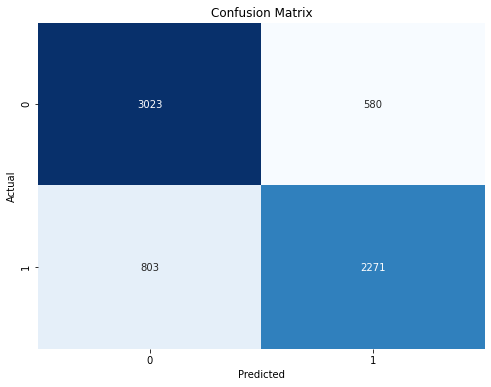

In [36]:
cm = confusion_matrix(y_test, best_tree_y_pred)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Logistic Regression

In [40]:
log_pipe = Pipeline([('ct', col_tr),
    ('logistic', LogisticRegression(max_iter=1000))])

In [41]:
log_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('impute_nums',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('num',
                                                                   StandardScaler())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'opinion_h1n1_vacc_effective',
                                                   'opinion_h1n1_risk',
                                                   'opinion_h1n1_sick_from_vacc',
                                       

In [42]:
cv_results = cross_validate(estimator=log_pipe, X=X_train, y=y_train, cv=5,
                            return_train_score=True)
cv_results

{'fit_time': array([ 8.51482773, 10.13447571,  5.82045293,  5.33355308,  4.94822478]),
 'score_time': array([0.08744311, 0.07810211, 0.06857324, 0.07792306, 0.07748222]),
 'test_score': array([0.79081378, 0.79955067, 0.8017973 , 0.79605592, 0.80129805]),
 'train_score': array([0.80404393, 0.80086121, 0.80036196, 0.80416875, 0.80279581])}

In [43]:
log_y_train = log_pipe.predict(X_train)
log_y_pred = log_pipe.predict(X_test)

In [44]:
print(precision_score(y_train, log_y_train))
print(precision_score(y_test, log_y_pred))

0.8041120650700406
0.803076923076923


In [38]:
log_params = {'logistic__C': [0.001, 0.01, 0.1, 1, 10]}

gs_log = GridSearchCV(log_pipe, log_params, scoring='precision')

gs_log.fit(X_train, y_train)

print(gs_log.best_params_)
print(gs_log.best_score_)

{'logistic__C': 0.1}
0.8003924028819258


In [46]:
best_log = Pipeline([('ct', col_tr),
    ('logistic', LogisticRegression(C=.1, max_iter=1000))])
best_log.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('impute_nums',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('num',
                                                                   StandardScaler())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'opinion_h1n1_vacc_effective',
                                                   'opinion_h1n1_risk',
                                                   'opinion_h1n1_sick_from_vacc',
                                       

In [47]:
best_log_y_train = best_log.predict(X_train)
best_log_y_pred = best_log.predict(X_test)

In [48]:
print(precision_score(y_train, best_log_y_train))
print(precision_score(y_test, best_log_y_pred))

0.804571687224171
0.8036264112213479


ROC curve

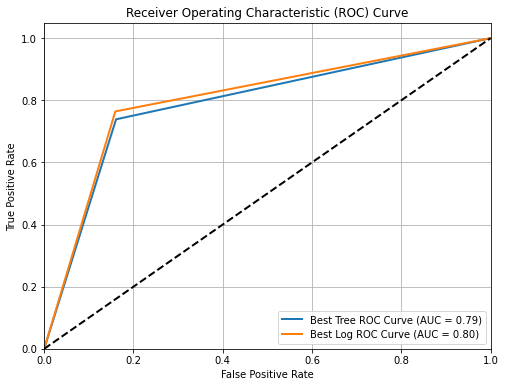

In [52]:
roc_auc = roc_auc_score(y_test, best_tree_y_pred)
roc_auc2 = roc_auc_score(y_test, best_log_y_pred)

fpr, tpr, _ = roc_curve(y_test, best_tree_y_pred)
fpr2, tpr2, _ = roc_curve(y_test, best_log_y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label='Best Tree ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot(fpr2, tpr2, linewidth=2, label='Best Log ROC Curve (AUC = {:.2f})'.format(roc_auc2))
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [33]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(final_model, X_train_tr, y_train, cv=5, scoring='accuracy')

In [34]:
mean_accuracy = scores.mean()
std_accuracy = scores.std()

print(f'Mean Accuracy: {mean_accuracy}')
print(f'Standard Deviation of Accuracy: {std_accuracy}') #low std: consistency, reliability, generalization

Mean Accuracy: 0.7979530703944084
Standard Deviation of Accuracy: 0.004097510639776977


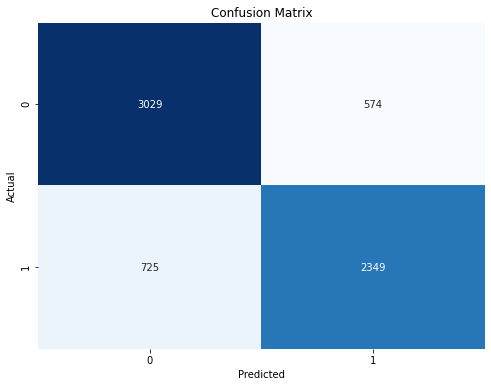

In [53]:
cm = confusion_matrix(y_test, best_log_y_pred)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [49]:
feature_names = ['x','h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine']  

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients[0]})

coef_df['Abs_Coefficient'] = abs(coef_df['Coefficient'])
sorted_coef = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print(sorted_coef)

ValueError: arrays must all be same length

In [50]:
print(len(feature_names))
print(len(coefficients[0]))  

37
143
